In [1]:
import pandas as pd
import numpy as np
import torch
import os

dataset_path = './dataset/'
dataset_files = ['TcData.csv' ,'BsData.csv']

dfs = dict([])
for file in dataset_files:
    df = pd.read_csv(os.path.join(dataset_path,file), na_values=0)
    df = df.rename(columns={'Composition': 'formula'})
    df.name = file[:2]
    dfs[df.name] = df

In [2]:
dfs['Tc'].describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
count,98.000000,98.000000,220.000000,220.000000
mean,1668.527573,735.758597,21.677273,599.232518
std,1439.796336,74.034270,3.351607,73.767177
min,60.000000,573.000000,17.500000,370.000000
25%,240.000000,679.500000,20.000000,587.000000
50%,1800.000000,745.514655,20.000000,605.983795
75%,3600.000000,780.500000,22.500000,626.768258
max,3857.047930,924.632090,30.000000,769.000000


In [3]:
dfs['Bs'].describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Bs (T)
count,242.000000,242.000000,294.000000,294.000000
mean,1214.834711,707.543060,23.423469,1.556457
std,1137.973090,88.279149,5.147990,0.281092
min,60.000000,543.000000,13.000000,0.259860
25%,600.000000,630.000000,20.000000,1.473255
50%,600.000000,703.348170,22.000000,1.650000
75%,1800.000000,773.000000,25.000000,1.738235
max,3840.000000,973.000000,76.000000,1.888650


In [4]:
from utils import add_feature

load_df = True
for df_name, df in dfs.items():
    if load_df:
        dfs[df_name] = pd.read_pickle(os.path.join(dataset_path, f"./df_data_{df.name}.pkl"))
    else:    
        name = df.name
        df = add_feature.add_composition(df)
        df = add_feature.add_element_fraction(df)
        df.name = name
        dfs[df_name] = df 
        df.to_pickle(os.path.join(dataset_path, f"./df_data_{df.name}.pkl"))

In [5]:
dfs['Tc'].describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K),H,He,Li,Be,B,C,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
count,98.000000,98.000000,220.000000,220.000000,220.0,220.0,220.0,220.0,220.000000,220.000000,...,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0
mean,1668.527573,735.758597,21.677273,599.232518,0.0,0.0,0.0,0.0,0.087652,0.013330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1439.796336,74.034270,3.351607,73.767177,0.0,0.0,0.0,0.0,0.037477,0.023594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,60.000000,573.000000,17.500000,370.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,240.000000,679.500000,20.000000,587.000000,0.0,0.0,0.0,0.0,0.075000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1800.000000,745.514655,20.000000,605.983795,0.0,0.0,0.0,0.0,0.090000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,3600.000000,780.500000,22.500000,626.768258,0.0,0.0,0.0,0.0,0.100000,0.020000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3857.047930,924.632090,30.000000,769.000000,0.0,0.0,0.0,0.0,0.235625,0.090000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from utils.surrogate import surrogate_model

Tc_surrogate = surrogate_model(name='Tc', df=dfs['Tc'])
Bs_surrogate = surrogate_model(name='Bs', df=dfs['Bs'])

In [7]:
Tc_surrogate.cleanup_df(drop_NaN = False, drop_col_with_NaN = True)
Bs_surrogate.cleanup_df(drop_NaN = False, drop_col_with_NaN = True)
Tc_surrogate.split_train_test(test_size=0.2,seed=1)
Bs_surrogate.split_train_test(test_size=0.2, seed=1)

In [7]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
#from botorch.fit import fit_gpytorch_mll
from torch.optim import SGD, Adam
from botorch.models.transforms.input import ChainedInputTransform
from utils.model import trainGP, NormalizeElementFractions, NormalizeFeatures
from utils.model import test_features_normalized

outcome_transform = Standardize(m=1)
normalize_other = NormalizeFeatures(indices=scale_col)
normalize_EF = NormalizeElementFractions(indices=EF_col)
input_transform = ChainedInputTransform(
    tf1=normalize_other, 
    tf2=normalize_EF,
)
model = SingleTaskGP(torch.tensor(X_train), 
                     torch.tensor(y_train).unsqueeze(dim=1),
                     input_transform=input_transform,
                     outcome_transform=outcome_transform,
                     covar_module=ScaleKernel(RBFKernel()),
)

print('Model is invariance to scaling non-ratio features: {}'.format(test_features_normalized(model, indices = scale_col)))
print('Model is invariance to scaling elemental fractions: {}'.format(test_features_normalized(model, indices = EF_col)))

load_state = False
model_path = './models/'
model_name = 'B_GP.torch'

if load_state:
    model.load_state_dict(torch.load(os.path.join(model_path,model_name)))
    model.eval()

else:
    #optimizer_kwargs = {'lr': 1e-2, 'weight_decay': 1e-3}
    optimizer_kwargs = {'lr': 5e-2, 'weight_decay': 1e-4}
    model.train()
    trainGP(model,
            #X_train = torch.tensor(X_train),
            mll = ExactMarginalLogLikelihood(model.likelihood, model), 
            optimizer = SGD([{'params': model.parameters()}], **optimizer_kwargs),
            num_epochs=500,
            print_interval = 100 
           )
    torch.save(model.state_dict(), os.path.join(model_path,model_name))

/Users/jingsk/software/Fe_alloy_phaseshift/utils/model.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = model.posterior(torch.tensor(X, dtype=torch.double))


Model is invariance to scaling non-ratio features: True
Model is invariance to scaling elemental fractions: True
Epoch 100/500 - Loss: 1.366 noise: 1.188
Epoch 200/500 - Loss: 1.234 noise: 0.574
Epoch 300/500 - Loss: 1.124 noise: 0.420
Epoch 400/500 - Loss: 0.786 noise: 0.123
Epoch 500/500 - Loss: 0.731 noise: 0.106


In [8]:
from sklearn.metrics import mean_squared_error, r2_score    
from utils.model import evaluateGP
from scipy.stats import linregress

y_train_predicted, y_train_stddev = evaluateGP(model, X_train)
y_test_predicted, y_test_stddev = evaluateGP(model, X_test)

for y_true, y_pred, l in zip([y_train, y_test],
                             [y_train_predicted, y_test_predicted],
                             ['train', 'test']):

    print(f"{l} R2 = {linregress(y_true, y_pred).rvalue**2: .03f}")
    print(f'{l} RMSE = {np.sqrt(mean_squared_error(y_true,y_pred)):.3f}')

train R2 =  0.927
train RMSE = 0.080
test R2 =  0.718
test RMSE = 0.118


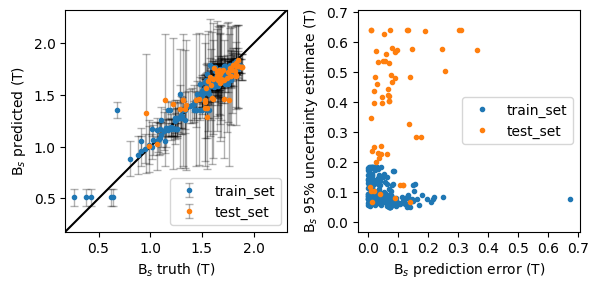

In [9]:
#from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

fig, axs = plt.subplots(1,2, figsize=[6,3])

for y_truth, y_model, stddev, l in zip([y_train, y_test],
                                  [y_train_predicted, y_test_predicted],
                                  [y_train_stddev, y_test_stddev],
                                  ['train_set', 'test_set']
                                 ):
    yerr = 2*np.array([stddev,stddev])
    markers, caps, bars = axs[0].errorbar(y_truth, y_model, yerr=yerr, label=l,
                                          fmt='.',capsize=3, elinewidth=1, ecolor = "black")
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    axs[1].plot(np.abs(y_truth-y_model), 2*stddev,'.', label=l)


for ax in axs:

    ymin = np.min([ax.get_xlim()[0], ax.get_ylim()[0]])
    ymax = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    ax.set_xlim([ymin, ymax])
    ax.set_ylim([ymin, ymax])
    ax.legend()
    loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.set_aspect('equal', 'box')

axs[0].set_xlabel(r'B$_{s}$ truth (T)')
axs[0].set_ylabel(r'B$_{s}$ predicted (T)')
axs[0].axline((0, 0), slope=1, color='k')

axs[1].set_xlabel(r'B$_{s}$ prediction error (T)')
axs[1].set_ylabel(r'B$_{s}$ 95% uncertainty estimate (T)')

fig.tight_layout()
fig.savefig('gp.png', dpi=300)